# Setup

In [1]:
# Import libraries 
import yaml
import string
import requests

# Recall from the APIs for Data lab that including passwords in code is a terrible practice. 
# So we include a yaml file.
config_file = open('GCP_model_details.yaml', 'r')
config = yaml.safe_load(config_file)

In [2]:
from google.cloud import aiplatform

In [3]:
def endpoint_predict_sample(
    project: str, location: str, instances: list, endpoint: str
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint)

    prediction = endpoint.predict(instances=instances)
    return prediction

# PCA for Predictions

In [4]:
# Importing data manipulation libraries and PCA tools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import KernelPCA
import itertools

In [5]:
%%bigquery base

SELECT 
    idDrink,
    strDrink,
    strIngredient1,
    strIngredient2,
    strIngredient3,
    strIngredient4,
    strIngredient5,
    strIngredient6,
    strIngredient7,
    strIngredient8,
    strIngredient9,
    strIngredient10,
    strIngredient11,
    strIngredient12,
    strIngredient13,
    strIngredient14,
    strIngredient15
FROM `bookish-journey-343419.cocktails_dataset.cocktails-table`

Downloading: 100%|██████████| 425/425 [00:00<00:00, 475.33rows/s]


In [6]:
# Drop empty columns
base = base.drop(['strIngredient12','strIngredient13','strIngredient14','strIngredient15'],axis=1)

# Replace NaN with ""
base = base.replace(np.nan,"")

# Create a ner variable, ingredients, that has all the previous ingredients together. 
base['ingredients'] = base[['strIngredient1','strIngredient2','strIngredient3','strIngredient4','strIngredient5',
        'strIngredient6','strIngredient7','strIngredient8','strIngredient9','strIngredient10','strIngredient11']].agg(','.join, axis=1)

# Function to transform letters to lowercase.
def lower(text):
    text=text.lower()
    return text

# Pass all words throw the funtion and append them
ingredients_low=[]
for i in base.ingredients:
    il=lower(i)
    ingredients_low.append(il)

# Lowercase
base['ingredients']=ingredients_low

# This function convert a list of ingredients into a dictionary, note: every ingredient gets a 1.
# this mean that the value of every key is 1. key:value
def convert_to_dict(lst):
    d = {} #empty dict
    for ingre in lst:
        d[ingre] = 1
    return d

# We use the function to convert every row into a dictionary. 
# 'vodka': 1, 'lime juice': 1... this will help us later to create a one hot encoding.
base['bagofwords'] = base.ingredients.str.split(',').apply(convert_to_dict)

# One Hot Encoding
# To find similarities between dishes and cluster cocktails using their ingredients, we will represent a recipe by a one-hot encoded vector 
# of its ingredients. We will be establishing a vocabulary of ingredients using a method ‘DictVectorizer’ provided in the sklearn library

# DictVectorizer:This transformer turns lists of mappings (dict-like objects) of feature names to feature values into Numpy arrays or scipy.sparse matrices for use with scikit-learn estimators.
# sparse, default=True. Whether transform should produce scipy.sparse matrices. In this case we set it as False.

vector_dict = DictVectorizer(sparse = False)

# fit_transform() is used on the training data so that we can scale the training data and also learn the scaling parameters of that data. 
#The fit method is calculating the mean and variance of each of the features present in our data. 
#The transform method is transforming all the features using the respective mean and variance.
# We past every dictionary into a list.
X = vector_dict.fit_transform(base["bagofwords"].tolist())

# We select the column strDrink(name of the drink) from de dataset
y = base.strDrink

# Using Kernel PCA
# kernel = "cosine": This is called cosine similarity, because Euclidean (L2) normalization projects the vectors onto the unit sphere, and their dot product is then the cosine of the angle between the points denoted by the vectors.

kpca = KernelPCA(n_components=2,kernel="cosine", n_jobs=2)

# Using the transform method we can use the same mean and variance as it is calculated from our training data to transform our test data. 
#Thus, the parameters learned by our model using the training data will help us to transform our test data.
x_pca = kpca.fit_transform(X)

# Testing Mean Shift Clustering

In [7]:
preds = endpoint_predict_sample(project = config['project_id'], location = config['region'], instances = x_pca.tolist(), endpoint = str(config['meanshift_endpoint_id']))
label = np.array(preds[0])

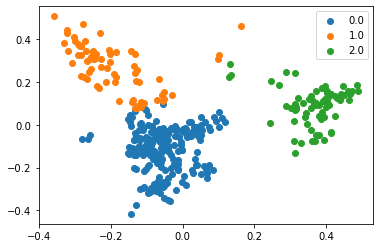

In [8]:
# Getting unique labels
u_labels = np.unique(label)
 
# Plotting the results:
for i in u_labels:
    plt.scatter(x_pca[label == i , 0] , x_pca[label == i , 1] , label = i)
plt.legend()
plt.show()

In [9]:
# Recommendations
def cluster_recomm(index,n_return=5):
    cluster = endpoint_predict_sample(project = config['project_id'], \
                                      location = config['region'], \
                                      instances = [x_pca[index].tolist()], \
                                      endpoint = str(config['meanshift_endpoint_id']))
    cluster_map = pd.DataFrame()
    cluster_map['cluster'] = np.array(endpoint_predict_sample(project = config['project_id'], \
                                                     location = config['region'], \
                                                     instances = x_pca.tolist(), \
                                                     endpoint = str(config['meanshift_endpoint_id']))[0])
    in_cluster = cluster_map[cluster_map.cluster == cluster[0][0]].sample(n=n_return, random_state = 42)
    return y[in_cluster.index]

In [10]:
# First Experiment
print(y[10])
cluster_recomm(10)

Thai Iced Coffee


47         Bumble Bee
170      Whiskey Sour
118    Nutty Irishman
314              Adam
315              H.D.
Name: strDrink, dtype: object

In [11]:
# Second Experiment
print(y[100])
cluster_recomm(100)

Port Wine Flip


47         Bumble Bee
170      Whiskey Sour
118    Nutty Irishman
314              Adam
315              H.D.
Name: strDrink, dtype: object

In [12]:
# Third Experiment
print(y[15])
cluster_recomm(15)

Fruit Shake


47         Bumble Bee
170      Whiskey Sour
118    Nutty Irishman
314              Adam
315              H.D.
Name: strDrink, dtype: object

# Testing K-Means Clustering

In [16]:
# Using Kernel PCA
# kernel = "cosine": This is called cosine similarity, because Euclidean (L2) normalization projects the vectors onto the unit sphere, and their dot product is then the cosine of the angle between the points denoted by the vectors.

kpca = KernelPCA(n_components=6,kernel="cosine", n_jobs=2)

# Using the transform method we can use the same mean and variance as it is calculated from our training data to transform our test data. 
#Thus, the parameters learned by our model using the training data will help us to transform our test data.
x_pca = kpca.fit_transform(X)

In [17]:
preds = endpoint_predict_sample(project = config['project_id'], location = config['region'], instances = x_pca.tolist(), endpoint = str(config['kmeans_endpoint_id']))
label = np.array(preds[0])

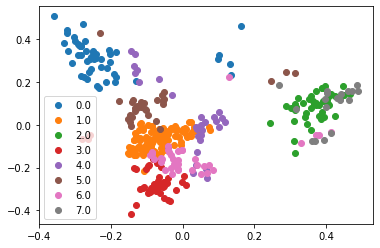

In [18]:
# Getting unique labels
u_labels = np.unique(label)
 
# Plotting the results:
for i in u_labels:
    plt.scatter(x_pca[label == i , 0] , x_pca[label == i , 1] , label = i)
plt.legend()
plt.show()

In [19]:
# Recommendations
def cluster_recomm(index,n_return=5):
    cluster = endpoint_predict_sample(project = config['project_id'], \
                                      location = config['region'], \
                                      instances = [x_pca[index].tolist()], \
                                      endpoint = str(config['kmeans_endpoint_id']))
    cluster_map = pd.DataFrame()
    cluster_map['cluster'] = np.array(endpoint_predict_sample(project = config['project_id'], \
                                                     location = config['region'], \
                                                     instances = x_pca.tolist(), \
                                                     endpoint = str(config['kmeans_endpoint_id']))[0])
    in_cluster = cluster_map[cluster_map.cluster == cluster[0][0]].sample(n=n_return, random_state = 42)
    return y[in_cluster.index]

In [20]:
# First Experiment
print(y[10])
cluster_recomm(10)

Thai Iced Coffee


324    New York Sour
175    Sweet Sangria
188        Tia-Maria
295         Spice 75
262       Egg Nog #4
Name: strDrink, dtype: object

In [21]:
# Second Experiment
print(y[100])
cluster_recomm(100)

Port Wine Flip


143        Gin Sling
129           Zoksel
44     Japanese Fizz
272        Rum Toddy
407    Funk and Soul
Name: strDrink, dtype: object

In [22]:
# Third Experiment
print(y[15])
cluster_recomm(15)

Fruit Shake


338           Stone Sour
217    Valencia Cocktail
303               Mimosa
251               Apello
140       Darkwood Sling
Name: strDrink, dtype: object